In [1]:
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26
import gcm_filters
import gcsfs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load example data
fs = gcsfs.GCSFileSystem()
ds = load_and_combine_cm26(fs)
ds

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [3]:
da = ds.isel(time=0)['surface_temp'].load()
da

<xarray.DataArray 'surface_temp' (yt_ocean: 2700, xt_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time      object 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [71]:
# make filters
filter_scale = 50
transition_width = np.pi/2
#transition_width = np.pi
wet_mask = (~np.isnan(da)).astype(int)
dims = ['yt_ocean', 'xt_ocean']

gaussian_filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    transition_width=transition_width,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)

taper_filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    transition_width=transition_width,
    n_steps=200, 
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)

<string>:11: UserWarning: You have set n_steps below the default. Results might not be accurate.


In [72]:
taper_filter

Filter(filter_scale=50, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=1.5707963267948966, ndim=2, n_steps=200, grid_type=<GridType.REGULAR_WITH_LAND: 3>)

/tmp/ipykernel_631/2802304864.py:3: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 0.25])


(0.028284271247460344, 0.25)

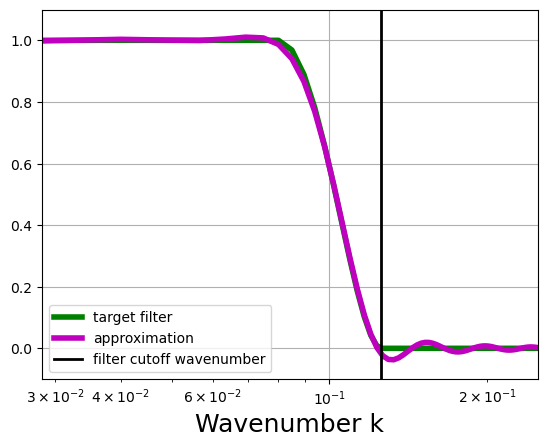

In [73]:
taper_filter.plot_shape()
plt.xscale('log')
plt.xlim([0, 0.25])

/tmp/ipykernel_631/2286688868.py:3: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 0.25])


(0.028284271247460344, 0.25)

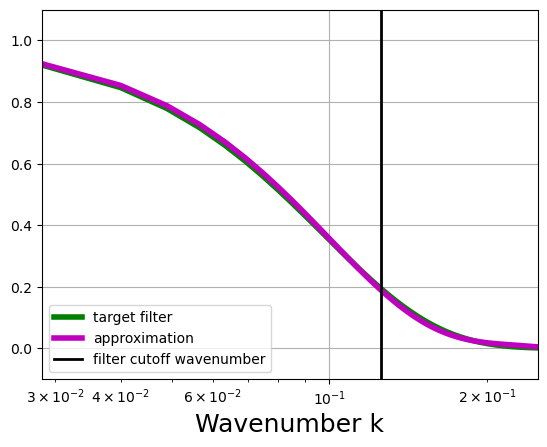

In [57]:
gaussian_filter.plot_shape()
plt.xscale('log')
plt.xlim([0, 0.25])

In [55]:
%%time
# apply filter and test time
da_gaussian = gaussian_filter.apply(da, dims=dims).load()

CPU times: user 19.2 s, sys: 11.5 s, total: 30.7 s
Wall time: 30.7 s


In [74]:
%%time
# apply filter and test time
da_taper = taper_filter.apply(da, dims=dims).load()

CPU times: user 1min 10s, sys: 42.2 s, total: 1min 52s
Wall time: 1min 52s


In [83]:
da_gaussian_double = gaussian_filter.apply(da_gaussian, dims=dims)
da_taper_double = taper_filter.apply(da_taper, dims=dims)

In [67]:
taper_filter.plot

Filter(filter_scale=50, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=1.5707963267948966, ndim=2, n_steps=388, grid_type=<GridType.REGULAR_WITH_LAND: 3>)

In [7]:
import xrft 

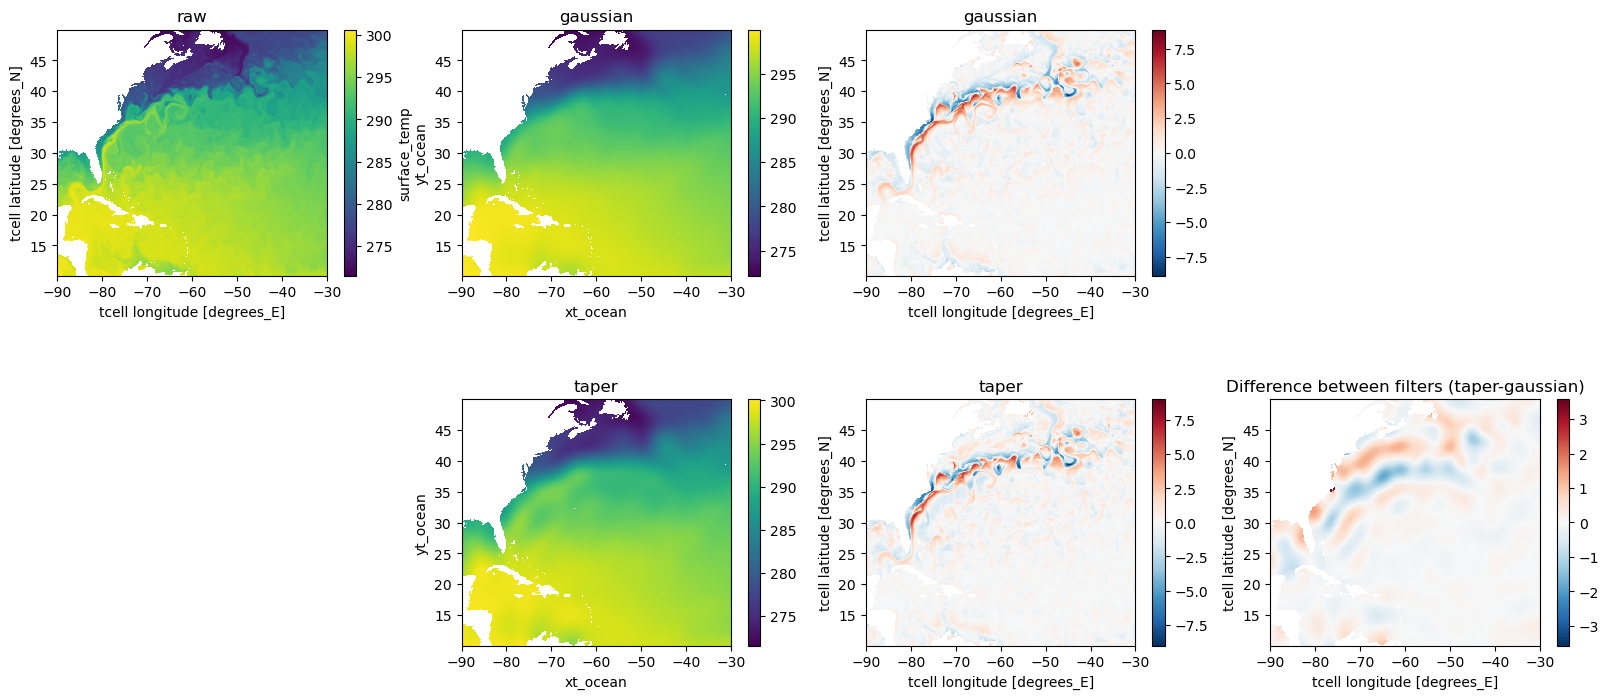

In [75]:
def sel_roi(da):
    return da.sel(xt_ocean=slice(-90, -30), yt_ocean=slice(10, 50))

plt.figure(figsize=[20,8])
plt.subplot(2,4,1)
sel_roi(da).plot()
plt.title('raw')
plt.subplot(2,4,2)
sel_roi(da_gaussian).plot()
plt.title('gaussian')
plt.subplot(2,4,3)
sel_roi(da-da_gaussian).plot()
plt.title('gaussian')

plt.subplot(2,4,6)
sel_roi(da_taper).plot()
plt.title('taper')
plt.subplot(2,4,7)
sel_roi(da-da_taper).plot()
plt.title('taper')
plt.subplot(2,4,8)
sel_roi((da-da_taper)-(da-da_gaussian)).plot()
plt.title('Difference between filters (taper-gaussian)')
plt.subplots_adjust(hspace=0.5)

Text(0.5, 1.0, 'taper double filter anomaly')

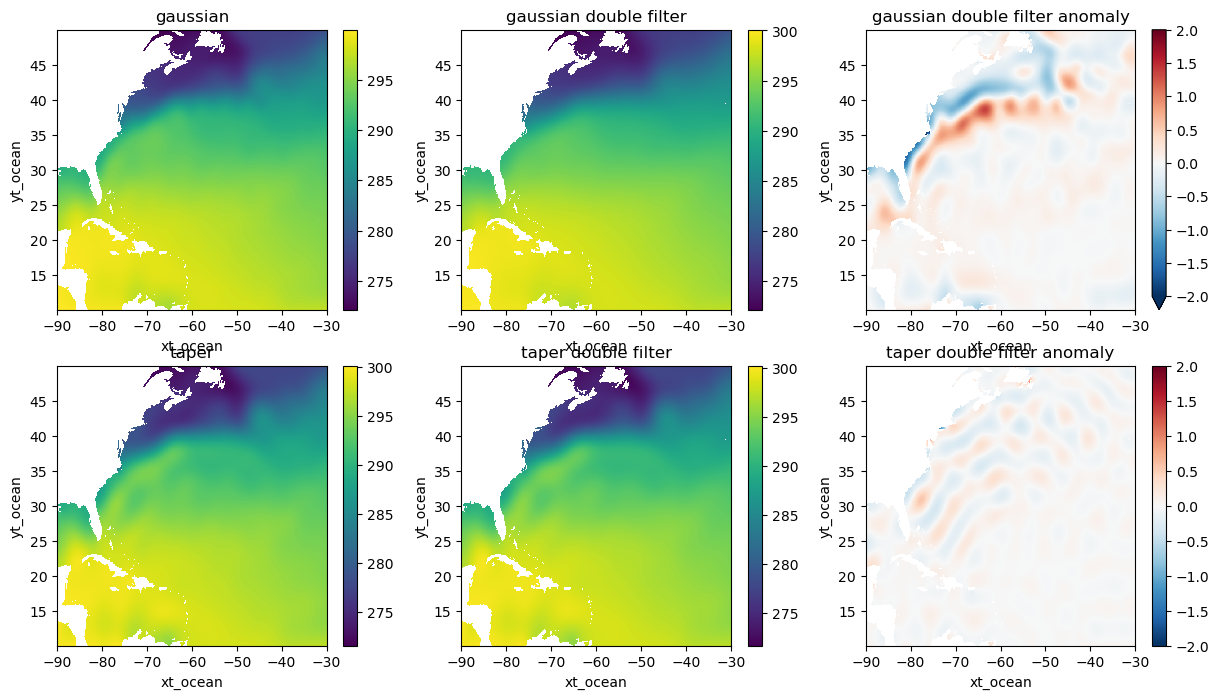

In [84]:
plt.figure(figsize=[20,8])
plt.subplot(2,4,1)
sel_roi(da_gaussian).plot()
plt.title('gaussian')
plt.subplot(2,4,2)
sel_roi(da_gaussian_double).plot()
plt.title('gaussian double filter')
plt.subplot(2,4,3)
sel_roi(da_gaussian-da_gaussian_double).plot(vmax=2)
plt.title('gaussian double filter anomaly')


plt.subplot(2,4,5)
sel_roi(da_taper).plot()
plt.title('taper')
plt.subplot(2,4,6)
sel_roi(da_taper_double).plot()
plt.title('taper double filter')
plt.subplot(2,4,7)
sel_roi(da_taper-da_taper_double).plot(vmax=2)
plt.title('taper double filter anomaly')

In [86]:
ds_sel=da.sel(xt_ocean=slice(-60, -26), yt_ocean=slice(25, 42)).interpolate_na('xt_ocean')
ds_gaussian_sel=da_gaussian.sel(xt_ocean=slice(-60, -26), yt_ocean=slice(25, 42)).interpolate_na('xt_ocean')
ds_taper_sel=da_taper.sel(xt_ocean=slice(-60, -26), yt_ocean=slice(25, 42)).interpolate_na('xt_ocean')

ds_gaussian_double_sel=da_gaussian_double.sel(xt_ocean=slice(-60, -26), yt_ocean=slice(25, 42)).interpolate_na('xt_ocean')
ds_taper_double_sel=da_taper_double.sel(xt_ocean=slice(-60, -26), yt_ocean=slice(25, 42)).interpolate_na('xt_ocean')



In [87]:
ds_sel_ps = xrft.power_spectrum(ds_sel, dim=['xt_ocean'], 
                                window=True, detrend='linear')
ds_gaussian_sel_ps = xrft.power_spectrum(ds_gaussian_sel, dim=['xt_ocean'], 
                                         window=True, detrend='linear')
ds_taper_sel_ps = xrft.power_spectrum(ds_taper_sel, dim=['xt_ocean'], 
                                      window=True, detrend='linear')

ds_gaussian_double_sel_ps = xrft.power_spectrum(ds_gaussian_double_sel, dim=['xt_ocean'], 
                                         window=True, detrend='linear')
ds_taper_double_sel_ps = xrft.power_spectrum(ds_taper_double_sel, dim=['xt_ocean'], 
                                      window=True, detrend='linear')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Ple

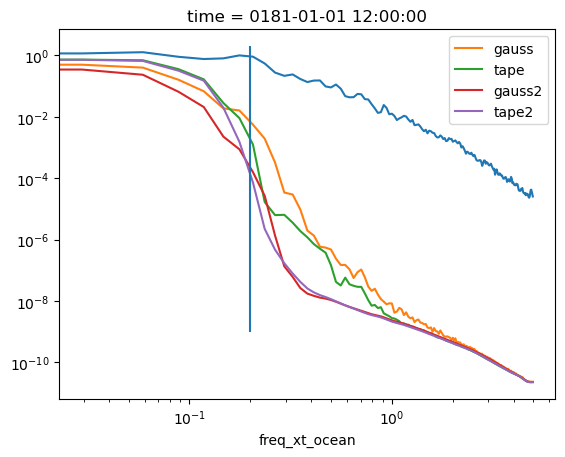

In [89]:
ds_sel_ps.mean('yt_ocean').plot()
ds_gaussian_sel_ps.mean('yt_ocean').plot(label='gauss')
ds_taper_sel_ps.mean('yt_ocean').plot(label='tape')

ds_gaussian_double_sel_ps.mean('yt_ocean').plot(label='gauss2')
ds_taper_double_sel_ps.mean('yt_ocean').plot(label='tape2')

plt.legend()
filter_scale_lat = filter_scale*0.1
plt.vlines(1/filter_scale_lat, 1e-9, 2)
plt.xscale('log')
plt.yscale('log')

In [82]:
filter_scale_lat*100

500.0